In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats
import dask
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

# Get data

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/020723_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'

In [4]:
all_illumina_cpg_locs_df = pd.read_csv(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"), sep=',', dtype={'CHR': str}, low_memory=False)
all_illumina_cpg_locs_df = all_illumina_cpg_locs_df.rename({"CHR": "chr", "MAPINFO":"start", "IlmnID": "#id"}, axis=1)
# get rows of all_illumina_cpg_locs_df where 'exon' appears in UCSC_RefGene_Group
all_illumina_cpg_locs_df.dropna(subset=['UCSC_RefGene_Group'], inplace=True)
exon_cpg_locs_df = all_illumina_cpg_locs_df[all_illumina_cpg_locs_df['UCSC_RefGene_Group'].str.contains('Body')]
cpg_in_body = exon_cpg_locs_df['Name'].to_list()

In [5]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [6]:
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)
# drop gender columns because most functions are not updated to work with this
all_methyl_age_df_t.drop(columns=['gender'], inplace=True)
all_mut_w_age_df.drop(columns=['gender'], inplace=True)

# Comethylation disturbance analysis

In [11]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 5, max_dist = 1000,
    num_correl_sites = 100, num_background_events = 100,
    matched_sample_num = 20
    )

In [40]:
# took 6min for 8 fully processed events and 1000 correl sites
# took 4min for 8 fully processed events and 100 correl sites
comparison_sites_df_test, all_metrics_df_test = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 2,
    linkage_method='correl', 
    out_dir = out_dir, 
    corr_direction = 'pos'
    )

Number mutation events being processed: 100


Getting mut site delta MF: 100%|██████████| 29/29 [00:00<00:00, 2743.48it/s]

Number mutation events being processed after filtering for delta_mf and MAF: 2



getting background sites: 100%|██████████| 2/2 [01:23<00:00, 41.69s/it]


Wrote comparison sites df to /cellar/users/zkoch/methylation_and_mutation/output_dirs/020723_output/comparison_sites_0-2Muts_100corrSites_pos_qnorm3SD_100background


Calculating effect of mutation on comparison sites: 100%|██████████| 202/202 [00:52<00:00,  3.84it/s]

Done getting effect of mutation on each site
got all metrics


writing results to /cellar/users/zkoch/methylation_and_mutation/output_dirs/020723_output/all_metrics_0-2Muts_100corrSites_pos_qnorm3SD_100background


### Read in results

In [7]:
all_metrics_dd = dask.dataframe.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/021323_comethylation_disturbance_output/all_metrics_0-500Muts_100corrSites_pos_qnorm3SD_100background")
all_metrics_df = all_metrics_dd.compute()

comparison_sites_dd = dask.dataframe.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/021323_comethylation_disturbance_output/comparison_sites_0-500Muts_100corrSites_pos_qnorm3SD_100background")
comparison_sites_df = comparison_sites_dd.compute()

In [16]:
comparison_sites_df['index_event'].value_counts()

TCGA-21-5787_2:85663660      100
TCGA-06-0171_9:96080326      100
TCGA-05-4410_1:152538380     100
TCGA-19-5953_16:31435264     100
TCGA-22-5473_22:19747140     100
TCGA-05-4410_12:4919230      100
TCGA-22-5473_19:51015807     100
TCGA-14-1034_11:237014       100
TCGA-21-5783_16:27761089     100
TCGA-19-5952_9:131669841     100
TCGA-21-5786_5:175815445     100
TCGA-05-4410_7:119915076     100
TCGA-05-4427_1:981164        100
TCGA-22-4593_1:21031088      100
TCGA-05-4390_18:48256146     100
TCGA-22-5478_1:159283536     100
TCGA-05-5428_2:68873233      100
TCGA-06-6697_2:169939876     100
TCGA-05-4415_16:67698948     100
TCGA-22-4599_5:76249897      100
TCGA-05-5425_16:3406339      100
TCGA-22-5479_11:103908576    100
TCGA-06-5415_19:46056784     100
TCGA-21-5787_19:45567390     100
TCGA-22-4593_19:10791697     100
TCGA-21-5782_14:94752574     100
TCGA-06-6699_7:108524200     100
TCGA-22-5489_1:203054889     100
TCGA-18-4721_6:7247354       100
self                          29
Name: inde

### P-value correction

In [12]:
# get significance status based on background pvalues
all_metrics_df_corrected = mut_scan.correct_pvals(all_metrics_df)
# get rid of background mutation event rows and non mutated sample rows
mut_event_metrics = all_metrics_df.loc[(all_metrics_df['mutated_sample'] == True) & (all_metrics_df['is_background'] == False), :]
# matchup significance statuses with actual pvalues and effect sizes
corrected_metrics_df = mut_event_metrics.merge(all_metrics_df_corrected[['mut_event', 'mf_pval2_sig', 'mf_pval_sig',
       'delta_mf_pval2_sig', 'delta_mf_pval_sig', 'abs_delta_mf_pval_sig']], on='mut_event', how='left', suffixes=None)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  return merge(


### Volcano plot

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

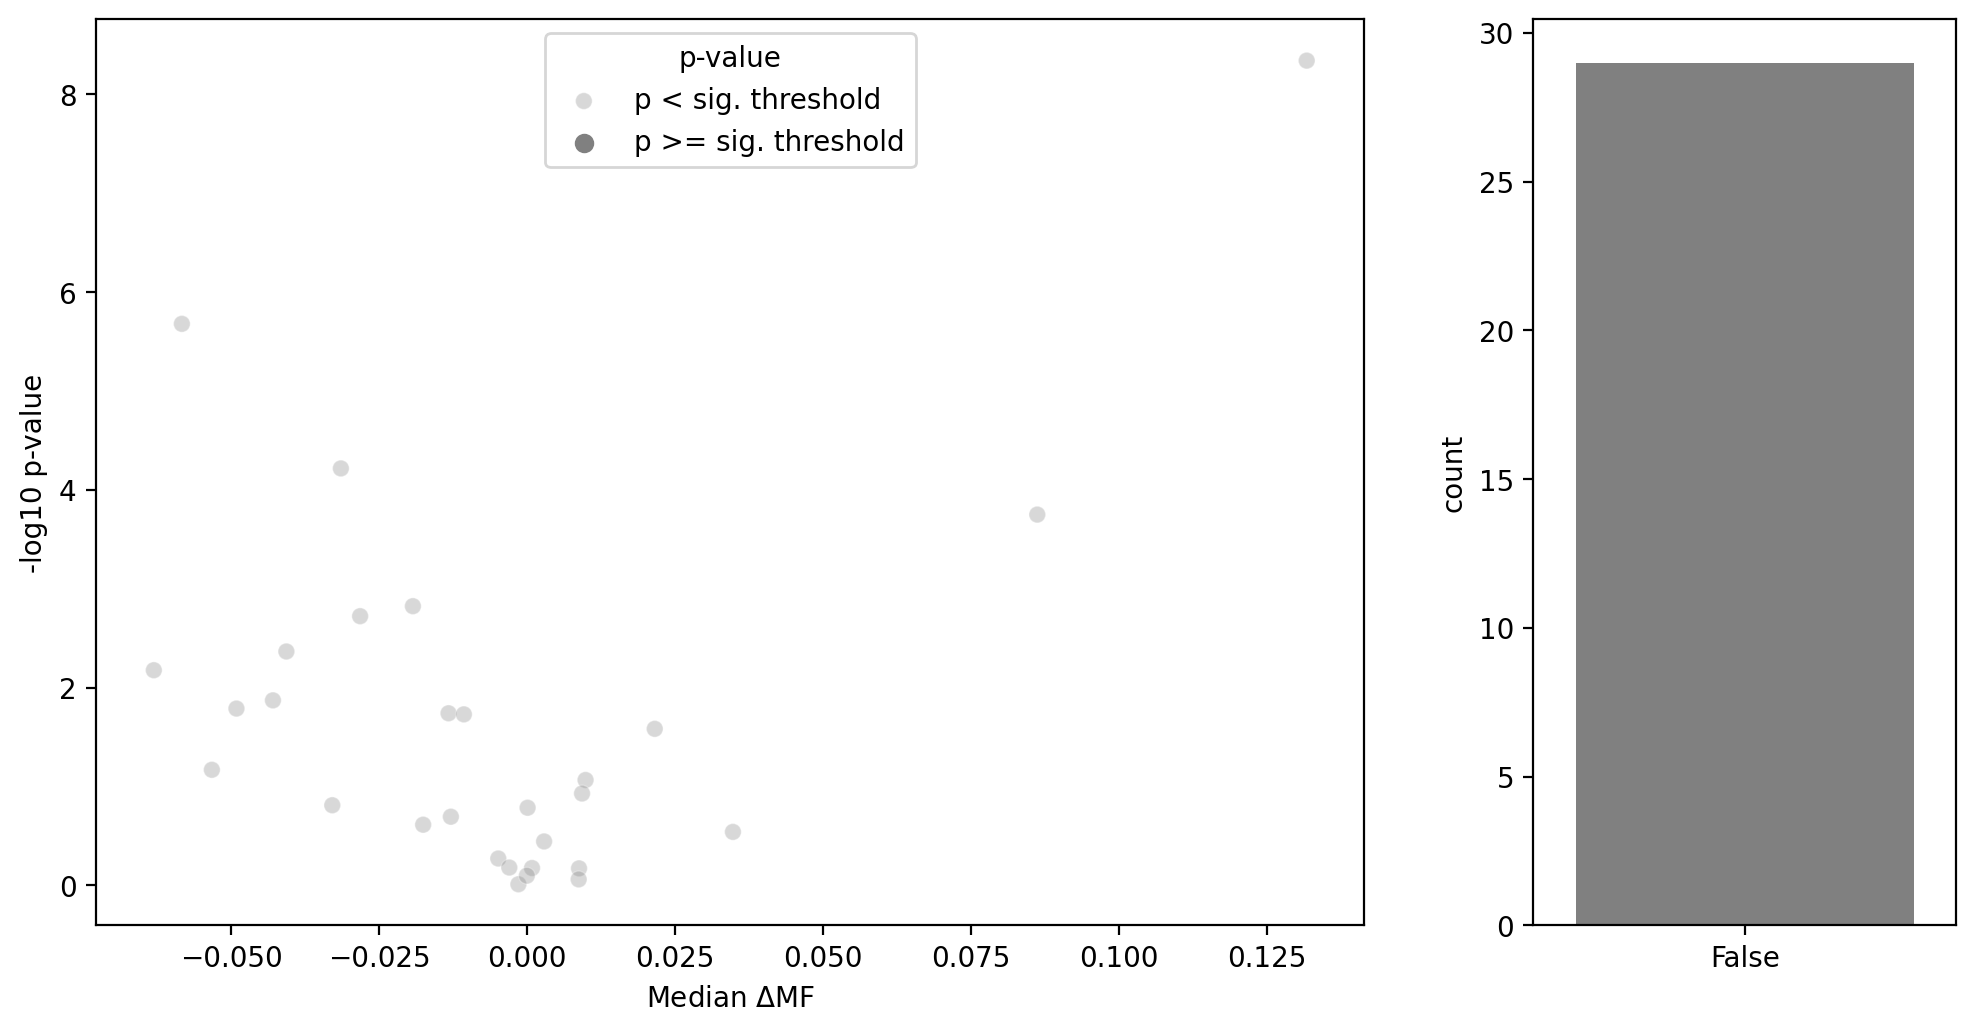

In [13]:
mut_scan.volcano_plot(corrected_metrics_df, pval_col = 'mf_pval2')